# Part 1: A Feature Tracker (50 Points)

In [ ]:
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import math
# from google.colab.patches import cv2_imshow
import random

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
data = loadmat('initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/sequence/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

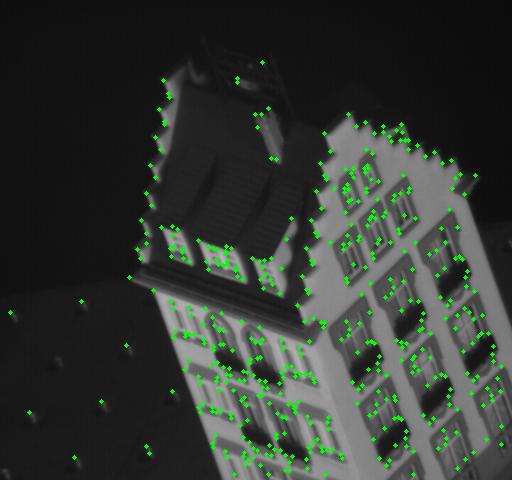

In [ ]:
def get_gradient(frame,X):
  if(X):
    sobelx = cv2.Sobel(frame,cv2.CV_64F,1,0,ksize=5)
    return sobelx
  else:
    sobely = cv2.Sobel(frame,cv2.CV_64F,0,1,ksize=5)
    return sobely

def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  # YOUR CODE HERE
  sum = 0
  imgc = img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  Iy, Ix = np.gradient(img)
  Ixx = np.square(Ix)
  Iyy = np.square(Iy)
  Ixy = Ix * Iy
  final_image = np.zeros((img.shape[0],img.shape[1]))

  window_size = 5
  for x in range(0,img.shape[0]-window_size+1):
    for y in range(img.shape[1]-window_size+1):
      sum_x = np.sum(Ixx[x:x+window_size+1, y:y+window_size+1])
      sum_y = np.sum(Iyy[x:x+window_size+1, y:y+window_size+1])
      sum_xy = np.sum(Ixy[x:x+window_size+1, y:y+window_size+1])

      M = np.array([[sum_x,sum_xy],[sum_xy, sum_y]])
      det = np.linalg.det(M)
      trace = np.trace(M)
      R = det - tau * (trace**2)
      final_image[x][y] = R
  
  key_points = []
  
  final_image = cv2.normalize(final_image, final_image, 0, 1, cv2.NORM_MINMAX)
  for y in range(window_size,final_image.shape[0]-window_size):
    for x in range(window_size,final_image.shape[1]-window_size):
      if final_image[y][x] > 0.287:  #0.287 for numpy gradients
        max = final_image[y][x]
        skip = False
        #Non Maximum Suppression
        for nrow in range(5):
          for ncol in range(5):
            if y + nrow -2 < final_image.shape[0] and x + ncol - 2 < final_image.shape[1]:
              if final_image[y+nrow -2][x + ncol -2] > max:
                skip = True
                break
        if not skip:
          cv2.circle(imgc,(x,y),2,(0,255,0),-1)
          key_points.append([y,x])
  cv2.imwrite('key_pts.jpg',imgc)
  key_points = np.array(key_points)
  return key_points, imgc

# compute keypoints in the first sequence
tau = 0.06
key_pts, image = getKeypoints(im[0], tau)

# add plots for the write-up
# YOUR CODE HERE
cv2.imshow('keypoints',image)
cv2.waitKey(0)

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

In [ ]:
def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
  im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
  h,w = im1.shape[0], im1.shape[1]
  fy, fx = np.gradient(im1)
  im1_smooth = cv2.GaussianBlur(im1,(5,5),1)
  im2_smooth = cv2.GaussianBlur(im2,(5,5),1)
  ft = im2 - im1
  X_pts = [0] * len(x) 
  Y_pts = [0] * len(y)
  w = ws//2
  window_size = (ws,ws)
  
  for ind in range(len(x)):
    Ix = cv2.getRectSubPix(fx, window_size, (x[ind],y[ind])).flatten()
    Iy = cv2.getRectSubPix(fy, window_size, (x[ind],y[ind])).flatten()
    It = cv2.getRectSubPix(ft, window_size, (x[ind],y[ind])).flatten()

    Ixx = np.sum(np.square(Ix))
    Iyy = np.sum(np.square(Iy))
    Ixy = np.sum(Ix*Iy)

    Ixt = np.sum(Ix*It)
    Iyt = np.sum(Iy*It)

    A = np.array([[Ixx, Ixy],
                  [Ixy, Iyy]])
    b = -np.array([[Ixt],
                  [Iyt]])
    A_inv = np.linalg.pinv(A)

    (u,v) = np.dot(A_inv,b)
    
    X_pts[ind] = u+x[ind]
    Y_pts[ind] = v+y[ind]

  return np.array(X_pts).reshape(len(x),), np.array(Y_pts).reshape(len(x),)

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function



Lucas Kanade Tracking


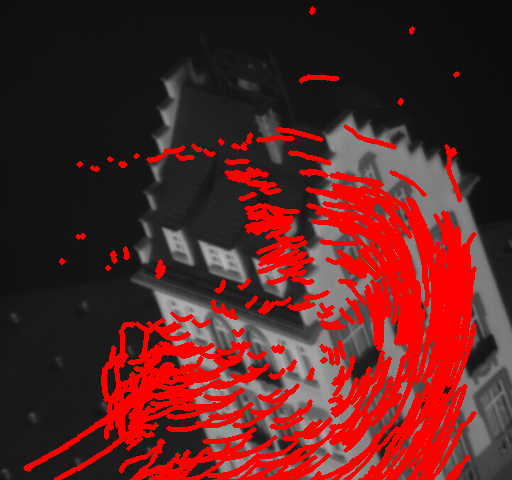

In [ ]:
ws = 15
X, Y = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

image_final = im[0].copy()


for x in range(X.shape[0]):
    for y in range(X.shape[1]-1):
        cv2.line(image_final,(int(X[x][y]),int(Y[x][y])),(int(X[x][y+1]),int(Y[x][y+1])),(0,0,255),3)
print("Lucas Kanade Tracking")
cv2.imshow('track',image_final)

Tracking 20 random points


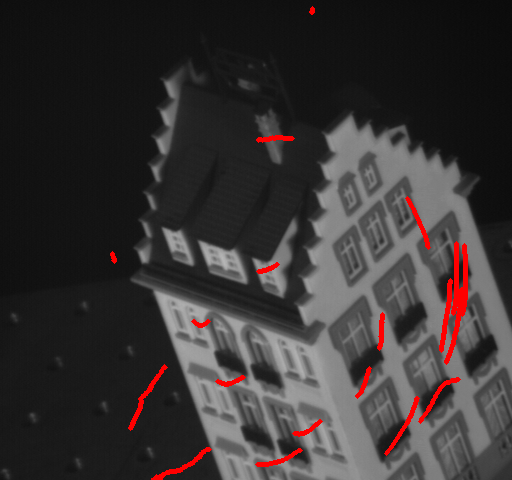

In [ ]:
# tau = 0.06
# key_pts, image = getKeypoints(im[0], tau)
keys = key_pts.copy()
random_key_points_20 = random.sample(np.ndarray.tolist(keys),20)
random_key_points_20 = np.array(random_key_points_20)

ws = 15
X, Y = trackPoints(pt_x=random_key_points_20[:,0], pt_y=random_key_points_20[:,1], im=im, ws=ws)

random_20= im[0].copy()
for x in range(X.shape[0]):
    for y in range(X.shape[1]-1):
        cv2.line(random_20,(int(X[x][y]),int(Y[x][y])),(int(X[x][y+1]),int(Y[x][y+1])),(0,0,255),3)
print("Tracking 20 random points")
cv2.imshow('20 random points',random_20)

Tracking points which go out of frame


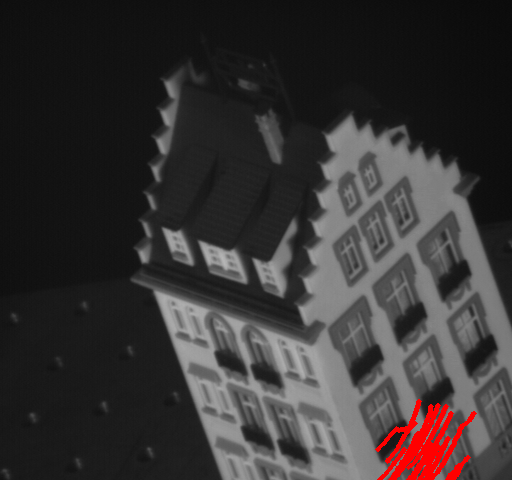

In [ ]:
# tau = 0.06
# key_pts, image = getKeypoints(im[0], tau)
keys = np.ndarray.tolist(key_pts.copy())
out_of_frame_img = im[0].copy()
out_of_frame = []
for i in keys:
    if i[0]>400 and i[1]>400:
        out_of_frame.append(i)
out_of_frame = np.array(out_of_frame)
ws = 15
X, Y = trackPoints(pt_x=out_of_frame[:,0], pt_y=out_of_frame[:,1], im=im, ws=ws)

for x in range(X.shape[0]):
    for y in range(X.shape[1]-1):
        cv2.line(out_of_frame_img,(int(X[x][y]),int(Y[x][y])),(int(X[x][y+1]),int(Y[x][y+1])),(0,0,255),3)
print("Tracking points which go out of frame")
cv2.imshow('out points',out_of_frame_img)

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





Write Up
1. Keypoints of first frame and tracking:


![](https://drive.google.com/uc?id=16uHdTxc1EK5bxrHhgzVbbiFqsNepkegC)
![](https://drive.google.com/uc?id=1Q1xXj_VV0u5HY3e7CiHB6EnnYdkRCO36)

2. 2D path of random 20 points(result keeps changing when run multiple times)


![](https://drive.google.com/uc?id=1GwrPBa8SbaqaTrMi07fZUdnFsWRUobdu)
3. Points which have moved out of frame:


![](https://drive.google.com/uc?id=1778zJ03_fOkyPHnwos3Dlku_Dgt1tsvW)
